## Note:
For more details regarding the steps involved in this notebook, please refer to **(3.1) Model for Under_20.ipynb**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import numpy as np 
import pandas as pd

import io
import json
import random
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
tokenizer = Tokenizer()

data = pd.read_csv('../../Data/sample2_above30.csv')
print("Number of sentences in the dataset:", data.shape[0])

corpus = data['0'].tolist()
random.shuffle(corpus)

# Tokenize the sentences
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print('There are %d unique words in total' %(total_words-1))

Number of sentences in the dataset: 5000
There are 11662 unique words in total


In [3]:
# Save tokenizer
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [7]:
input_sequences = []
for line in corpus: # iterate through the list of sentences
    # For each sentence, use the tokenizer to encode it into 
    # a sequence of numbers (word indices)
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    for i in range(1, len(token_list)): # iterate through the word 
                                        # indices of the sentence
        n_gram_sequence = token_list[:i+1] # create subset of the sentence
        input_sequences.append(n_gram_sequence)

# Determine the largest length of all sentences
max_sequence_len = max([len(x) for x in input_sequences]) 
print('The longest sentence has %d words' %max_sequence_len)

# Pad sequences (to the front)
input_sequences = np.array(pad_sequences(input_sequences, 
                                         maxlen=max_sequence_len, padding='pre'))

# Create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# One-hot encode the labels (target output)
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

The longest sentence has 35 words


In [5]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.title(string + " changes over epochs")
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

In [6]:
def text_generator(seed_text, next_words, tokenizer, 
                   model, max_sequence_len):
    '''
    Returns a block of text generated using a trained model.
    
    Parameters:
        seed_text (str): several words to start the block of text
        next_words (int): number of generated words desired
        tokenizer: tokenizer of the trained model
        model: trained model for text generation
        max_sequence_len: the biggest length of the sentences fed to the model
    '''
    for w in range(next_words):
        # Tokenize the previous words (i.e. the starting words when the 
        # text generation first begins)
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        # Pad sequences
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, 
                                   padding='pre')
        # Generate model predictions based on the padded sequences
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            # Look for the corresponding word of the predicted word index 
            # output by the model above
            if index == predicted:
                output_word = word
                break
        # Add the predicted word
        seed_text += " " + output_word
    return seed_text

### Initial Round

In [8]:
xs, ys = prepare_data(tokenizer, corpus, max_sequence_len)

# Construct the model
model = Sequential()
model.add(Embedding(total_words, 150, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.10))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=['accuracy'])

filepath = "model_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

history = model.fit(xs, ys, epochs=30, batch_size=64, verbose=1, 
                    callbacks=desired_callbacks)

print(model)
print(model.summary())

Epoch 1/30
1241/1241 [==============================] - 43s 27ms/step - loss: 7.7371 - accuracy: 0.0449

Epoch 00001: loss improved from inf to 7.73713, saving model to model_weights.hdf5
Epoch 2/30
1241/1241 [==============================] - 33s 26ms/step - loss: 8.3926 - accuracy: 0.0519

Epoch 00002: loss did not improve from 7.73713
Epoch 3/30
1241/1241 [==============================] - 32s 25ms/step - loss: 7.8149 - accuracy: 0.0559

Epoch 00003: loss did not improve from 7.73713
Epoch 4/30
1241/1241 [==============================] - 32s 25ms/step - loss: 7.7724 - accuracy: 0.0638

Epoch 00004: loss did not improve from 7.73713
Epoch 5/30
1241/1241 [==============================] - 32s 25ms/step - loss: 7.5946 - accuracy: 0.0674

Epoch 00005: loss improved from 7.73713 to 7.59457, saving model to model_weights.hdf5
Epoch 6/30
1241/1241 [==============================] - 32s 26ms/step - loss: 7.9289 - accuracy: 0.0684

Epoch 00006: loss did not improve from 7.59457
Epoch 7/30
1

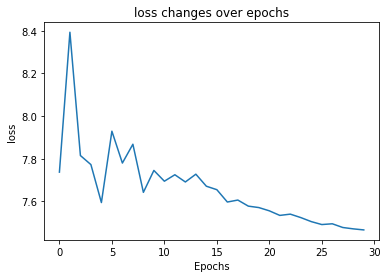

In [9]:
plot_graphs(history, 'loss')

The graph above shows that as the number of epoch increases, the training losses are declining with fluctuations. Towards epoch 30, the training losses have become more stable compared to earlier.

In [10]:
print(text_generator('i was home', 100, 
                     tokenizer, model, max_sequence_len))

i was home to register syndrome the woods to register the woods to register the woods to register the woods to register the woods to register the woods to register the woods to automate organisation to walmart a spice latest rates aloft to register unit aloft to register unit aloft to register to walmart to register walmart aj to register walmart admitting to walmart walmart admitting to walmart pleased to walmart aj switching switching rates to output to register organisation aloft to register organisation shamrock stone switching switching organisation in social organisation mountain syndrome influence to walmart switching influence 'i'm walmart walmart admitting


The text generated has shown some (although very little) sentence structure in the beginning. However, later on, some repetitions in phrases can be observed, and the model starts combining irrelevant words.

### After some tuning

In [11]:
# Construct the model
model = Sequential()
model.add(Embedding(total_words, 150, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(200)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=['accuracy'])

filepath = "model_weights2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min')
desired_callbacks = [checkpoint]

history = model.fit(xs, ys, epochs=25, batch_size=64, verbose=1, 
                    callbacks=desired_callbacks)

print(model)
print(model.summary())

Epoch 1/25
1241/1241 [==============================] - 28s 20ms/step - loss: 6.8668 - accuracy: 0.0821

Epoch 00001: loss improved from inf to 6.86684, saving model to model_weights2.hdf5
Epoch 2/25
1241/1241 [==============================] - 25s 20ms/step - loss: 5.9929 - accuracy: 0.1204

Epoch 00002: loss improved from 6.86684 to 5.99291, saving model to model_weights2.hdf5
Epoch 3/25
1241/1241 [==============================] - 25s 20ms/step - loss: 5.2296 - accuracy: 0.1503

Epoch 00003: loss improved from 5.99291 to 5.22958, saving model to model_weights2.hdf5
Epoch 4/25
1241/1241 [==============================] - 25s 20ms/step - loss: 4.3601 - accuracy: 0.2049

Epoch 00004: loss improved from 5.22958 to 4.36007, saving model to model_weights2.hdf5
Epoch 5/25
1241/1241 [==============================] - 25s 20ms/step - loss: 3.5426 - accuracy: 0.2946

Epoch 00005: loss improved from 4.36007 to 3.54262, saving model to model_weights2.hdf5
Epoch 6/25
1241/1241 [=================

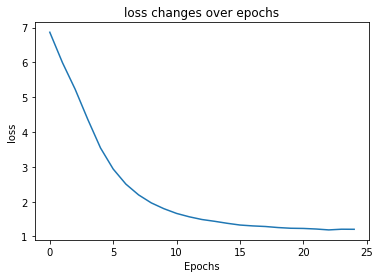

In [12]:
plot_graphs(history, 'loss')

The above graph shows that as the number of epoch increases, the training losses have been decreasing first rapidly then steadily. When it approaches 25 epochs, the losses are becoming stable.

In [13]:
print(text_generator('i was home', 100, 
                     tokenizer, model, max_sequence_len))

i was home so real all the time i hit the big breakfast at the case study americans die to which included the president's why of this is a terrible idea sloppy chili and spaghetti aren't smart when you can't feel anything east to anyone he isn't having anyone better than other countries old how much writing can often if she shouldn't be as a good looking watching after a long long list of links from my sidebar is gone and just like it had the chance to wanting a different to have a camper a good place to be the place used


Compared to the text generated before, the one output by the tuned model hasn't shown problems of repeating words. Moreover, some phrases can be observed in the block of text. However, it appears that the text doesn't make much sense as sentence structures are still missing.